In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import scipy.stats as stats
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from time import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import power_transform
from sklearn import preprocessing

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


sns.set(style='ticks', color_codes = True)

In [2]:
# https://theakway.blog/2018/08/10/linear-regression-with-python-sklearn/

def rss(model,X,y):
    '''
    Function to calculate the residual sum of squared of the model
    Input:
        model: Trained linear regression model
        X: Training predictors as a pandas dataframe
        y: Training responses as a pandas dataframe
    Output:
        The RSS of the model
    '''
    res = y - model.predict(X)
    return sum(res**2)
 
def rse(model,X,y):
    '''
    Function to calculate the residual standard error of the model
    Input:
        model: Trained linear regression model
        X: Training predictors as a pandas dataframe
        y: Training responses as a pandas dataframe
    Output:
        The RSE of the model
    '''
    return np.sqrt(rss(model,X,y)/(X.shape[0]-X.shape[1]-1))
 
def studresidplot(model,X,y,threshold=3,ax=None, **kwargs):
    '''
    This function plots a studentized residual plot
    Inputs:
        model = Trained sklearn model
        X: Predictors as a pandas dataframe
        y: Responses as a pandas dataframe
        Threshold: Threshold to identify outliers
        kwargs: seaborn.residplot arguments
    Output:
        Boolean mask for outliers(False if outlier)
    '''
    vals = {'Studentized Residuals': (y-model.predict(X))/rse(model,X,y), 'Predicted Values': model.predict(X)}
    resdf = pd.DataFrame(vals)
    resdf['Outlier'] = resdf['Studentized Residuals'].apply(lambda x: 'Outlier' if abs(x)>= threshold else 'Normal')
    #ax = sns.lmplot(y='Studentized Residuals',x='Predicted Values', hue='Outlier' , data=resdf, fit_reg=False, **kwargs)
    ax = sns.scatterplot(y='Studentized Residuals',x='Predicted Values', hue='Outlier' , data=resdf, ax=ax, **kwargs)
    return resdf['Studentized Residuals'].apply(lambda x: False if abs(x)>= 3 else True)

# Reading in data

In [3]:
# song features
songfeat_mean = pd.read_csv('songfeatures_filteragg_mean.csv', sep=",")
songfeat_median = pd.read_csv('songfeatures_filteragg_median.csv', sep=",")

# ticket features
ticket_mean = pd.read_csv('seatgeek_ticket_filteragg_mean.csv', sep=",")
ticket_median = pd.read_csv('seatgeek_ticket_filteragg_median.csv', sep=",")

# Shape info
print(songfeat_mean.shape)
print(songfeat_median.shape)

print(ticket_mean.shape)
print(ticket_median.shape)

(5345, 12)
(5345, 12)
(4557, 31)
(4557, 31)


In [4]:
songfeat_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345 entries, 0 to 5344
Data columns (total 12 columns):
artist              5345 non-null object
track_number        5345 non-null float64
acousticness        5345 non-null float64
danceability        5345 non-null float64
energy              5345 non-null float64
instrumentalness    5345 non-null float64
liveness            5345 non-null float64
loudness            5345 non-null float64
speechiness         5345 non-null float64
tempo               5345 non-null float64
valence             5345 non-null float64
popularity          5345 non-null float64
dtypes: float64(11), object(1)
memory usage: 501.2+ KB


In [5]:
# songfeat_mean[songfeat_mean['artist'].str.contains('maniacs')]

In [6]:
ticket_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4557 entries, 0 to 4556
Data columns (total 31 columns):
performers_name                          4557 non-null object
performers_id                            4557 non-null int64
Unnamed: 0                               4557 non-null float64
enddatetime_utc                          0 non-null float64
id                                       4557 non-null float64
performers_num_upcoming_events           4557 non-null float64
performers_popularity                    4557 non-null float64
performers_score                         4557 non-null float64
popularity                               4557 non-null float64
score                                    4557 non-null float64
stats_average_price                      4557 non-null float64
stats_highest_price                      4557 non-null float64
stats_listing_count                      4557 non-null float64
stats_lowest_price                       4557 non-null float64
stats_lowest_pric

# Merging the Ticket and Music Data

In [7]:
mean_df = pd.merge(ticket_mean, songfeat_mean, right_on='artist', left_on='performers_name', how='inner')
mean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3850 entries, 0 to 3849
Data columns (total 43 columns):
performers_name                          3850 non-null object
performers_id                            3850 non-null int64
Unnamed: 0                               3850 non-null float64
enddatetime_utc                          0 non-null float64
id                                       3850 non-null float64
performers_num_upcoming_events           3850 non-null float64
performers_popularity                    3850 non-null float64
performers_score                         3850 non-null float64
popularity_x                             3850 non-null float64
score                                    3850 non-null float64
stats_average_price                      3850 non-null float64
stats_highest_price                      3850 non-null float64
stats_listing_count                      3850 non-null float64
stats_lowest_price                       3850 non-null float64
stats_lowest_pric

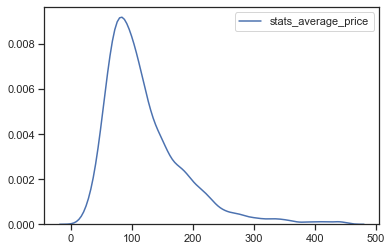

In [8]:
sns.kdeplot(mean_df.stats_average_price)

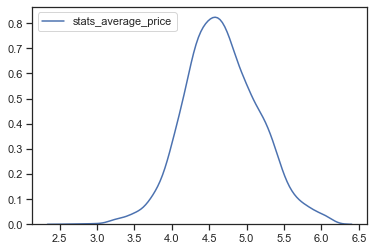

In [9]:
sns.kdeplot(np.log(mean_df.stats_average_price))

In [10]:
mean_df

,performers_name,performers_id,Unnamed: 0,enddatetime_utc,id,performers_num_upcoming_events,performers_popularity,performers_score,popularity_x,score,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
0,!!! (Chk Chk Chk),22271,4742.600000,NaN,4.909388e+06,6.000000,0.0,0.390000,0.269000,0.202200,...,0.082692,0.746218,0.774124,2.808613e-01,0.178466,-7.689427,0.078385,120.291973,0.613115,22.372727
1,(Sandy) Alex G,288439,66499.000000,NaN,4.977232e+06,5.000000,0.0,0.520000,0.211500,0.220000,...,0.436583,0.518501,0.507272,4.076341e-01,0.160320,-9.047859,0.039868,120.990370,0.411405,37.695652
2,070 Shake,610195,73402.461538,NaN,4.972756e+06,18.769231,0.0,0.456923,0.305000,0.302000,...,0.287187,0.693765,0.504647,9.187244e-03,0.166871,-8.579529,0.101606,120.564647,0.298753,46.588235
3,112,16858,37415.000000,NaN,4.964795e+06,1.000000,0.0,0.500000,0.260000,0.242000,...,0.235635,0.621328,0.537148,3.034816e-04,0.170666,-8.399313,0.081848,110.526211,0.542398,23.585938
4,12th Planet,7548,64991.000000,NaN,4.969690e+06,2.000000,0.0,0.470000,0.381000,0.378000,...,0.006144,0.562826,0.928348,2.344230e-01,0.272111,-2.725152,0.213448,127.152543,0.235948,27.478261
5,1349,247021,27275.333333,NaN,4.981462e+06,10.000000,0.0,0.390000,0.185500,0.150000,...,0.046970,0.254826,0.864070,4.812508e-01,0.350721,-7.405485,0.105506,120.060192,0.162683,9.584615
6,1964 The Tribute,2231,41413.500000,NaN,4.923804e+06,3.000000,0.0,0.470000,0.000000,0.000000,...,0.072593,0.496805,0.604732,4.224634e-02,0.470163,-9.935341,0.036434,134.004268,0.758854,0.731707
7,1TakeJay,698215,6436.000000,NaN,4.983259e+06,2.000000,0.0,0.620000,0.361000,0.269000,...,0.170140,0.781945,0.587956,4.899748e-04,0.153275,-8.640934,0.314367,113.524462,0.413996,30.461538
8,21 Gun Salute,746562,87654.000000,NaN,5.020375e+06,1.000000,0.0,0.000000,0.000000,0.000000,...,0.003400,0.386023,0.886674,1.580027e-01,0.251523,-7.441163,0.069279,135.526721,0.543777,0.674419
9,24hrs,608573,16912.333333,NaN,5.016056e+06,4.000000,0.0,0.440000,0.193333,0.144333,...,0.159086,0.759092,0.572338,2.131197e-04,0.163809,-7.000077,0.162837,133.788215,0.442934,26.630769


In [11]:
median_df = pd.merge(ticket_mean, songfeat_mean, right_on='artist', left_on='performers_name', how='inner')
median_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3850 entries, 0 to 3849
Data columns (total 43 columns):
performers_name                          3850 non-null object
performers_id                            3850 non-null int64
Unnamed: 0                               3850 non-null float64
enddatetime_utc                          0 non-null float64
id                                       3850 non-null float64
performers_num_upcoming_events           3850 non-null float64
performers_popularity                    3850 non-null float64
performers_score                         3850 non-null float64
popularity_x                             3850 non-null float64
score                                    3850 non-null float64
stats_average_price                      3850 non-null float64
stats_highest_price                      3850 non-null float64
stats_listing_count                      3850 non-null float64
stats_lowest_price                       3850 non-null float64
stats_lowest_pric

In [12]:
median_df

,performers_name,performers_id,Unnamed: 0,enddatetime_utc,id,performers_num_upcoming_events,performers_popularity,performers_score,popularity_x,score,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
0,!!! (Chk Chk Chk),22271,4742.600000,NaN,4.909388e+06,6.000000,0.0,0.390000,0.269000,0.202200,...,0.082692,0.746218,0.774124,2.808613e-01,0.178466,-7.689427,0.078385,120.291973,0.613115,22.372727
1,(Sandy) Alex G,288439,66499.000000,NaN,4.977232e+06,5.000000,0.0,0.520000,0.211500,0.220000,...,0.436583,0.518501,0.507272,4.076341e-01,0.160320,-9.047859,0.039868,120.990370,0.411405,37.695652
2,070 Shake,610195,73402.461538,NaN,4.972756e+06,18.769231,0.0,0.456923,0.305000,0.302000,...,0.287187,0.693765,0.504647,9.187244e-03,0.166871,-8.579529,0.101606,120.564647,0.298753,46.588235
3,112,16858,37415.000000,NaN,4.964795e+06,1.000000,0.0,0.500000,0.260000,0.242000,...,0.235635,0.621328,0.537148,3.034816e-04,0.170666,-8.399313,0.081848,110.526211,0.542398,23.585938
4,12th Planet,7548,64991.000000,NaN,4.969690e+06,2.000000,0.0,0.470000,0.381000,0.378000,...,0.006144,0.562826,0.928348,2.344230e-01,0.272111,-2.725152,0.213448,127.152543,0.235948,27.478261
5,1349,247021,27275.333333,NaN,4.981462e+06,10.000000,0.0,0.390000,0.185500,0.150000,...,0.046970,0.254826,0.864070,4.812508e-01,0.350721,-7.405485,0.105506,120.060192,0.162683,9.584615
6,1964 The Tribute,2231,41413.500000,NaN,4.923804e+06,3.000000,0.0,0.470000,0.000000,0.000000,...,0.072593,0.496805,0.604732,4.224634e-02,0.470163,-9.935341,0.036434,134.004268,0.758854,0.731707
7,1TakeJay,698215,6436.000000,NaN,4.983259e+06,2.000000,0.0,0.620000,0.361000,0.269000,...,0.170140,0.781945,0.587956,4.899748e-04,0.153275,-8.640934,0.314367,113.524462,0.413996,30.461538
8,21 Gun Salute,746562,87654.000000,NaN,5.020375e+06,1.000000,0.0,0.000000,0.000000,0.000000,...,0.003400,0.386023,0.886674,1.580027e-01,0.251523,-7.441163,0.069279,135.526721,0.543777,0.674419
9,24hrs,608573,16912.333333,NaN,5.016056e+06,4.000000,0.0,0.440000,0.193333,0.144333,...,0.159086,0.759092,0.572338,2.131197e-04,0.163809,-7.000077,0.162837,133.788215,0.442934,26.630769


In [13]:
median_df.columns

Index(['performers_name', 'performers_id', 'Unnamed: 0', 'enddatetime_utc',
       'id', 'performers_num_upcoming_events', 'performers_popularity',
       'performers_score', 'popularity_x', 'score', 'stats_average_price',
       'stats_highest_price', 'stats_listing_count', 'stats_lowest_price',
       'stats_lowest_price_good_deals', 'stats_lowest_sg_base_price',
       'stats_lowest_sg_base_price_good_deals', 'stats_median_price',
       'stats_variants', 'stats_visible_listing_count', 'taxonomies_id',
       'taxonomies_parent_id', 'time_tbd', 'venue_capacity', 'venue_id',
       'venue_metro_code', 'venue_num_upcoming_events', 'venue_popularity',
       'venue_score', 'unique_venue_ratio', 'residency', 'artist',
       'track_number', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity_y'],
      dtype='object')

In [14]:
focus_col = ['performers_name',
       'performers_num_upcoming_events', 'performers_popularity',
       'performers_score', 'popularity_x', 'score', 'stats_average_price',
       'stats_highest_price', 'stats_listing_count', 'stats_lowest_price',
    'stats_median_price', 'venue_capacity', 'venue_id',
       'venue_metro_code', 'venue_popularity',
       'venue_score', 'residency', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity_y']

focus_numcol = ['performers_num_upcoming_events', 'stats_average_price',
       'stats_highest_price', 'stats_listing_count', 'stats_lowest_price',
    'stats_median_price', 'venue_capacity',
       'venue_metro_code', 'venue_popularity',
       'venue_score', 'residency', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity_y']

In [15]:
# Number of null values per column
for i in mean_df.columns:
    print(str(i) + " " + str((mean_df[i].isnull().sum()/len(mean_df))*100) + " "+ str(len(mean_df)) + " " + str((mean_df[i].isnull().sum())))

performers_name 0.0 3850 0
performers_id 0.0 3850 0
Unnamed: 0 0.0 3850 0
enddatetime_utc 100.0 3850 3850
id 0.0 3850 0
performers_num_upcoming_events 0.0 3850 0
performers_popularity 0.0 3850 0
performers_score 0.0 3850 0
popularity_x 0.0 3850 0
score 0.0 3850 0
stats_average_price 0.0 3850 0
stats_highest_price 0.0 3850 0
stats_listing_count 0.0 3850 0
stats_lowest_price 0.0 3850 0
stats_lowest_price_good_deals 65.5064935064935 3850 2522
stats_lowest_sg_base_price 0.0 3850 0
stats_lowest_sg_base_price_good_deals 65.5064935064935 3850 2522
stats_median_price 0.0 3850 0
stats_variants 100.0 3850 3850
stats_visible_listing_count 0.0 3850 0
taxonomies_id 0.0 3850 0
taxonomies_parent_id 100.0 3850 3850
time_tbd 0.0 3850 0
venue_capacity 0.0 3850 0
venue_id 0.0 3850 0
venue_metro_code 0.0 3850 0
venue_num_upcoming_events 0.0 3850 0
venue_popularity 0.0 3850 0
venue_score 0.0 3850 0
unique_venue_ratio 0.0 3850 0
residency 0.0 3850 0
artist 0.0 3850 0
track_number 0.0 3850 0
acousticness 0.0

# MEAN-EDA

## 1. What's the relationship between streaming popularity and average ticket price?

Text(0, 0.5, 'Streaming Popularity')

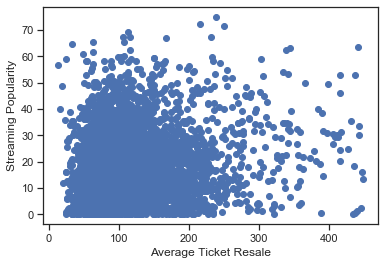

In [16]:
plt.scatter(mean_df['stats_average_price'], mean_df['popularity_y']);
plt.xlabel('Average Ticket Resale')
plt.ylabel('Streaming Popularity')

In [17]:
mean_df['stats_average_price'].corr(mean_df['popularity_y'], method='spearman')

0.12170325275412569

In [77]:
mean_df.shape

(3850, 43)

There is small, positive correlation between streamming popularity and average resale price.

# Feature Selection

In [18]:
# scatter_matrix(mean_df[focus_col]);

In [ ]:
scatter_matrix(mean_df[focus_numcol]);

## Correlation Matrix w/Heatmap

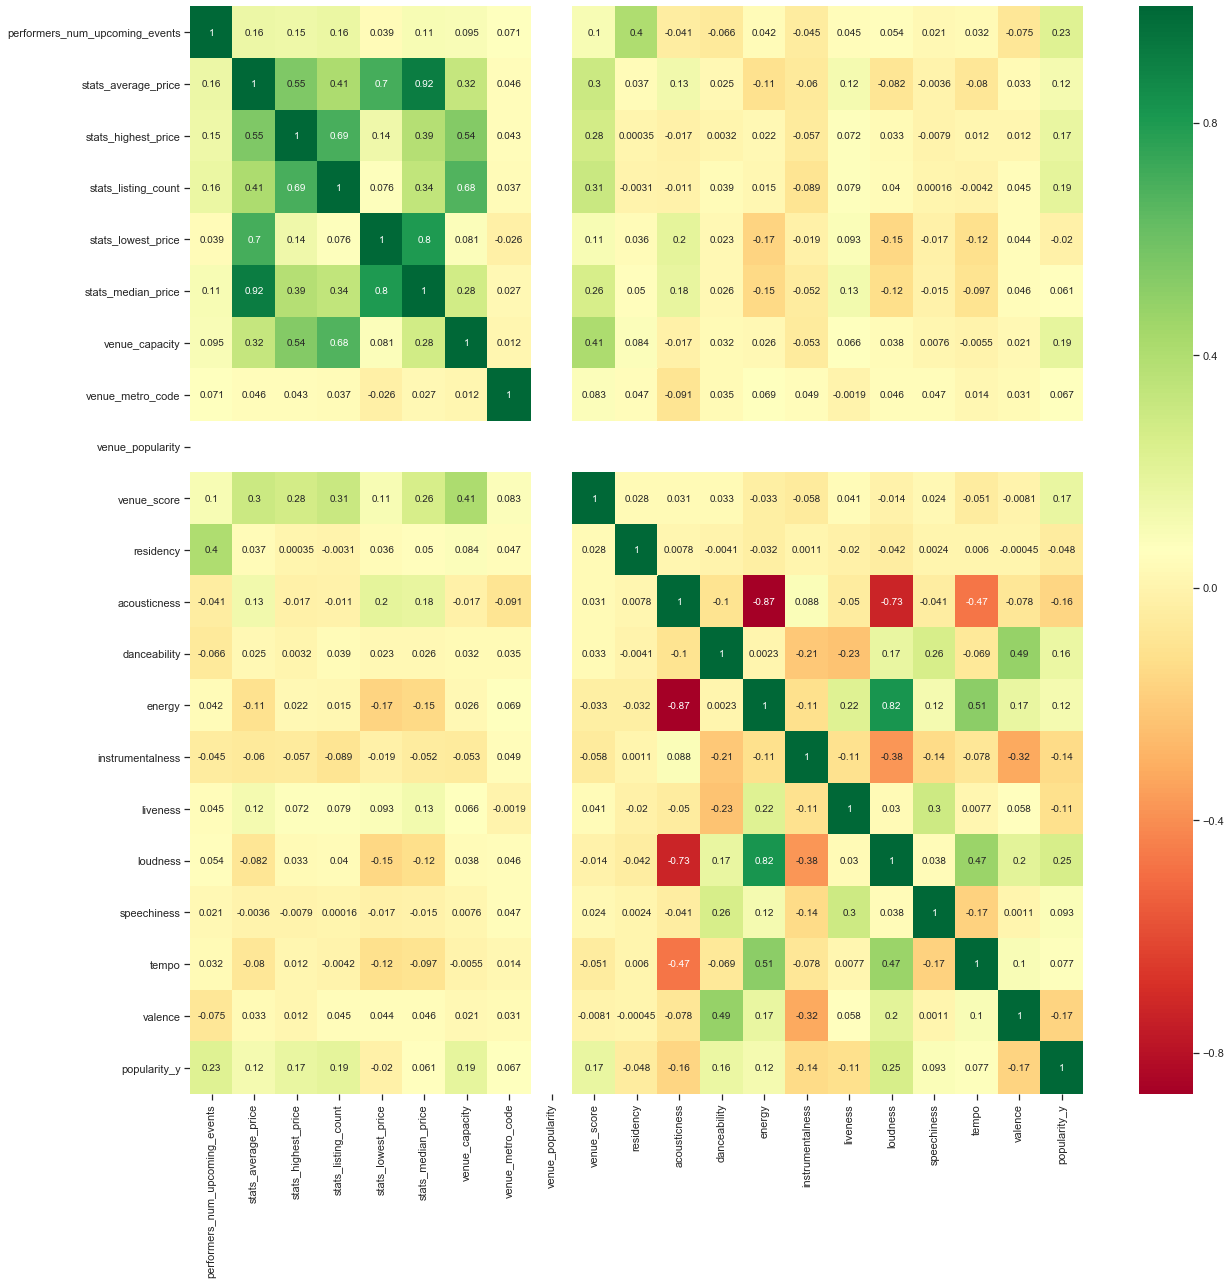

In [20]:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
corrmat = mean_df[focus_numcol].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
g = sns.heatmap(mean_df[focus_numcol][top_corr_features].corr(),annot=True,cmap="RdYlGn")
fig = g.get_figure()
fig.savefig("CorrelationMatrix_features.png")

When looking at the different features and their correlation to average resale price, it seems like there are a couple features that seem intresting: 

    - performers_num_upcoming_events
    - venue_capacity
    - venue_score
    - acouticness
    - energy
    - liveness
    - streamming popularity

In [21]:
# Using sklearn feature selection to test the individual effect of many regressors

possible_regressors = ['performers_num_upcoming_events', 'venue_capacity',
       'venue_metro_code',
       'venue_score', 'residency', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity_y']

f_regression(mean_df[possible_regressors], mean_df['stats_average_price'])

(array([9.71494632e+01, 4.47065813e+02, 8.00117144e+00, 3.93694858e+02,
        5.41386938e+00, 6.94427849e+01, 2.35279807e+00, 4.55526646e+01,
        1.37325639e+01, 5.70677271e+01, 2.63028513e+01, 5.09805245e-02,
        2.48285379e+01, 4.11500525e+00, 5.43988715e+01]),
 array([1.18962395e-22, 5.72731030e-94, 4.69889962e-03, 1.70137902e-83,
        2.00290391e-02, 1.08163670e-16, 1.25140567e-01, 1.70848043e-11,
        2.13732041e-04, 5.23006087e-14, 3.06239139e-07, 8.21377779e-01,
        6.54191224e-07, 4.25731280e-02, 1.99377347e-13]))

I dunno what this exact means. I think the F-test only gets linear dependency???

# LINEAR MODEL for INFERENCEEEEE!!!!

Let's built a basic linear model with no bells or whistles.

In [22]:
mean_df.head()

,performers_name,performers_id,Unnamed: 0,enddatetime_utc,id,performers_num_upcoming_events,performers_popularity,performers_score,popularity_x,score,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
0,!!! (Chk Chk Chk),22271,4742.600000,NaN,4.909388e+06,6.000000,0.0,0.390000,0.2690,0.2022,...,0.082692,0.746218,0.774124,0.280861,0.178466,-7.689427,0.078385,120.291973,0.613115,22.372727
1,(Sandy) Alex G,288439,66499.000000,NaN,4.977232e+06,5.000000,0.0,0.520000,0.2115,0.2200,...,0.436583,0.518501,0.507272,0.407634,0.160320,-9.047859,0.039868,120.990370,0.411405,37.695652
2,070 Shake,610195,73402.461538,NaN,4.972756e+06,18.769231,0.0,0.456923,0.3050,0.3020,...,0.287187,0.693765,0.504647,0.009187,0.166871,-8.579529,0.101606,120.564647,0.298753,46.588235
3,112,16858,37415.000000,NaN,4.964795e+06,1.000000,0.0,0.500000,0.2600,0.2420,...,0.235635,0.621328,0.537148,0.000303,0.170666,-8.399313,0.081848,110.526211,0.542398,23.585938
4,12th Planet,7548,64991.000000,NaN,4.969690e+06,2.000000,0.0,0.470000,0.3810,0.3780,...,0.006144,0.562826,0.928348,0.234423,0.272111,-2.725152,0.213448,127.152543,0.235948,27.478261


In [23]:
heatmap_feats = ['performers_num_upcoming_events', 'venue_capacity',
       'venue_score', 'acousticness', 'energy', 'liveness', 'popularity_y']

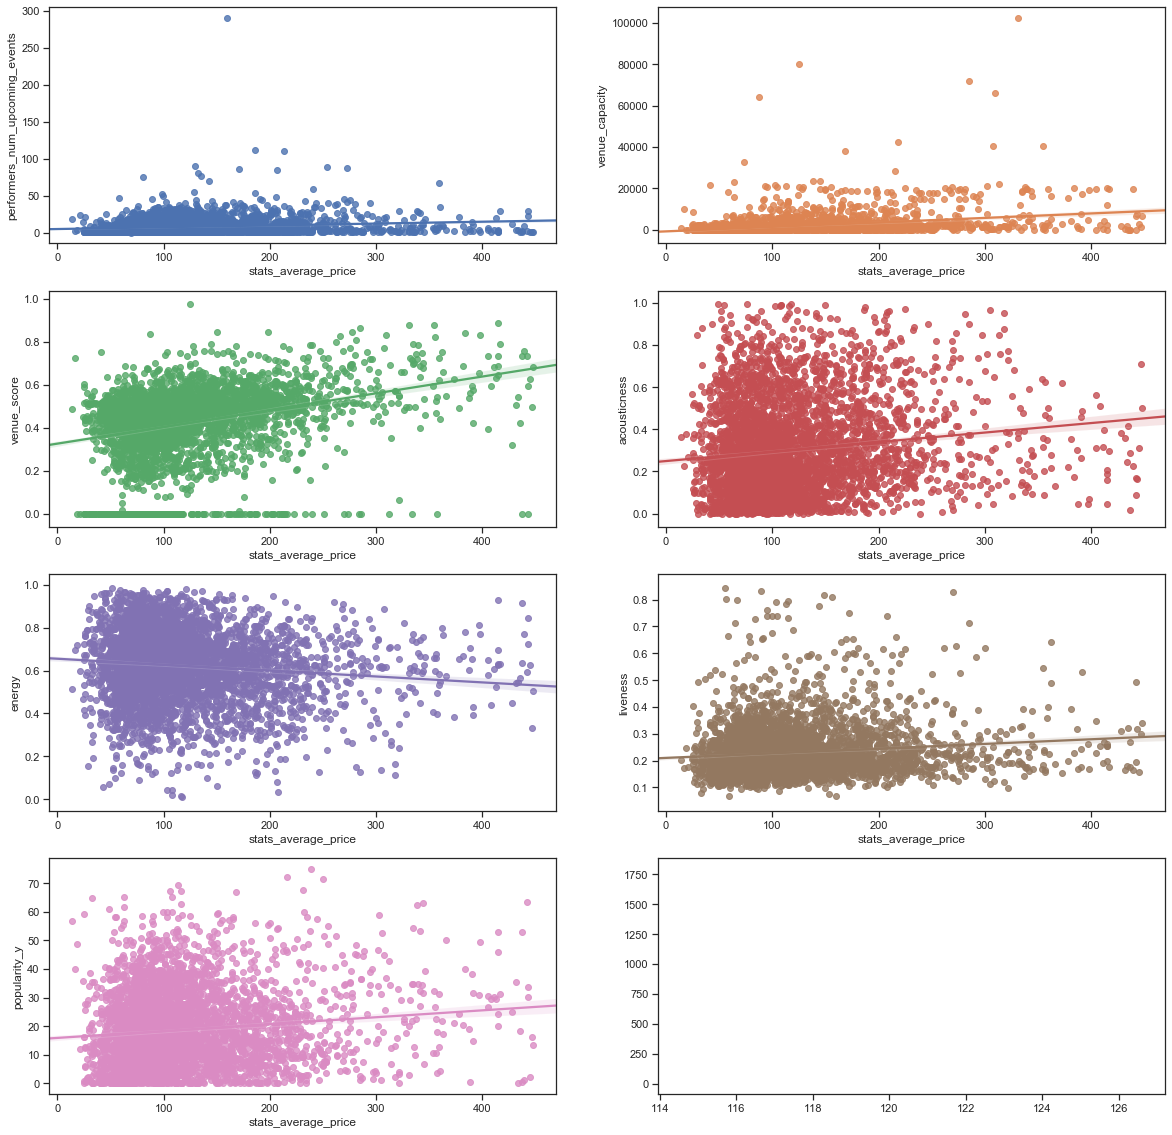

In [24]:
fig, axes = plt.subplots(4,2, figsize=(20,20))

for measure,ax in zip(heatmap_feats, axes.flat):
    sns.regplot(mean_df['stats_average_price'], mean_df[measure], ax = ax);

When looking at the scatterplot for stat_avg_price and the other noticable heatmap features, it seems like there are slight positive relationshipe between all the features, except for energy, which seems to be negative. However, very slight...not sure if any of the features, at least nontransformed with be good predictors??? They look sorta linear?

In [25]:
#Pairwise correlations
mean_df[heatmap_feats].corr()

,performers_num_upcoming_events,venue_capacity,venue_score,acousticness,energy,liveness,popularity_y
performers_num_upcoming_events,1.000000,0.094866,0.102154,-0.041320,0.042333,0.045212,0.225271
venue_capacity,0.094866,1.000000,0.409007,-0.016796,0.025699,0.065719,0.187044
venue_score,0.102154,0.409007,1.000000,0.030517,-0.032593,0.040600,0.172898
acousticness,-0.041320,-0.016796,0.030517,1.000000,-0.870642,-0.050341,-0.161829
energy,0.042333,0.025699,-0.032593,-0.870642,1.000000,0.220349,0.117344
liveness,0.045212,0.065719,0.040600,-0.050341,0.220349,1.000000,-0.114660
popularity_y,0.225271,0.187044,0.172898,-0.161829,0.117344,-0.114660,1.000000


From the pw correlations, it seems like there might be some correlations between the features --> multicollinearity. Especially between the venue measures and within the musical features too. Let's just do this regression and see.

In [26]:
y = mean_df['stats_average_price']
X = mean_df.drop(['stats_average_price',
       'stats_highest_price', 'stats_listing_count', 'stats_lowest_price',
       'stats_lowest_price_good_deals', 'stats_lowest_sg_base_price',
       'stats_lowest_sg_base_price_good_deals', 'stats_median_price',
       'stats_variants', 'stats_visible_listing_count', 'enddatetime_utc'], axis=1)

X.head()

,performers_name,performers_id,Unnamed: 0,id,performers_num_upcoming_events,performers_popularity,performers_score,popularity_x,score,taxonomies_id,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
0,!!! (Chk Chk Chk),22271,4742.600000,4.909388e+06,6.000000,0.0,0.390000,0.2690,0.2022,2000000.0,...,0.082692,0.746218,0.774124,0.280861,0.178466,-7.689427,0.078385,120.291973,0.613115,22.372727
1,(Sandy) Alex G,288439,66499.000000,4.977232e+06,5.000000,0.0,0.520000,0.2115,0.2200,2000000.0,...,0.436583,0.518501,0.507272,0.407634,0.160320,-9.047859,0.039868,120.990370,0.411405,37.695652
2,070 Shake,610195,73402.461538,4.972756e+06,18.769231,0.0,0.456923,0.3050,0.3020,2000000.0,...,0.287187,0.693765,0.504647,0.009187,0.166871,-8.579529,0.101606,120.564647,0.298753,46.588235
3,112,16858,37415.000000,4.964795e+06,1.000000,0.0,0.500000,0.2600,0.2420,2000000.0,...,0.235635,0.621328,0.537148,0.000303,0.170666,-8.399313,0.081848,110.526211,0.542398,23.585938
4,12th Planet,7548,64991.000000,4.969690e+06,2.000000,0.0,0.470000,0.3810,0.3780,2000000.0,...,0.006144,0.562826,0.928348,0.234423,0.272111,-2.725152,0.213448,127.152543,0.235948,27.478261


In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 193)

In [28]:
X_train

,performers_name,performers_id,Unnamed: 0,id,performers_num_upcoming_events,performers_popularity,performers_score,popularity_x,score,taxonomies_id,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
3752,Wingtip,567777,18125.285714,4.963325e+06,7.000000,0.0,0.450000,0.421429,0.361143,2000000.0,...,0.174291,0.688616,0.694535,0.025813,0.174047,-6.284566,0.085615,115.623434,0.506808,15.424242
2951,Solstice,30919,50431.000000,5.024078e+06,1.000000,0.0,0.360000,0.000000,0.000000,2000000.0,...,0.661455,0.587364,0.235527,0.234327,0.138809,-18.432727,0.101264,110.660000,0.344791,9.000000
3085,TRUST,19191,32583.000000,4.936899e+06,2.000000,0.0,0.430000,0.460000,0.343000,2000000.0,...,0.497862,0.703402,0.484676,0.424727,0.136557,-11.033717,0.068778,120.143250,0.523939,35.347826
2351,No Quarter,5060,72301.000000,5.022452e+06,1.000000,0.0,0.440000,0.000000,0.000000,2000000.0,...,0.039152,0.386057,0.963064,0.067212,0.247034,-4.098255,0.109126,127.924064,0.375155,1.276596
2217,Mike Gordon,4369,74794.000000,4.996766e+06,9.000000,0.0,0.438750,0.402750,0.389500,2000000.0,...,0.351083,0.567133,0.638327,0.319282,0.157196,-9.299212,0.060358,113.647691,0.660495,9.654545
2331,New Years Day,40005,10758.000000,5.005186e+06,15.000000,0.0,0.495000,0.514000,0.401500,2000000.0,...,0.031271,0.456323,0.885151,0.006085,0.184731,-4.122667,0.111820,138.921022,0.405888,30.139785
2822,Seal,1601,38618.000000,4.963540e+06,1.000000,0.0,0.530000,0.554000,0.511000,2000000.0,...,0.329352,0.539113,0.594149,0.026539,0.352015,-8.349504,0.068892,117.381418,0.477367,25.432624
3560,Tommy Emmanuel,1921,68268.857143,4.925551e+06,18.000000,0.0,0.460714,0.314214,0.322143,2000000.0,...,0.717636,0.517273,0.393399,0.549839,0.310737,-12.395361,0.050807,122.761608,0.489552,15.824742
2241,Mongol Horde,740810,55263.500000,4.915723e+06,3.000000,0.0,0.435000,0.497000,0.431000,2000000.0,...,0.209096,0.460857,0.697993,0.059293,0.205076,-6.025235,0.071214,128.875412,0.460854,3.319328
2225,Mini KISS,249653,18273.000000,4.955441e+06,1.000000,0.0,0.450000,0.000000,0.000000,2000000.0,...,0.252800,0.684315,0.652728,0.002312,0.154564,-6.243865,0.072891,123.516399,0.597831,7.398876


In [29]:
X_train.columns

Index(['performers_name', 'performers_id', 'Unnamed: 0', 'id',
       'performers_num_upcoming_events', 'performers_popularity',
       'performers_score', 'popularity_x', 'score', 'taxonomies_id',
       'taxonomies_parent_id', 'time_tbd', 'venue_capacity', 'venue_id',
       'venue_metro_code', 'venue_num_upcoming_events', 'venue_popularity',
       'venue_score', 'unique_venue_ratio', 'residency', 'artist',
       'track_number', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity_y'],
      dtype='object')

In [30]:
X_train[heatmap_feats]

,performers_num_upcoming_events,venue_capacity,venue_score,acousticness,energy,liveness,popularity_y
3752,7.000000,446.428571,0.421394,0.174291,0.694535,0.174047,15.424242
2951,1.000000,1800.000000,0.543996,0.661455,0.235527,0.138809,9.000000
3085,2.000000,600.000000,0.492207,0.497862,0.484676,0.136557,35.347826
2351,1.000000,0.000000,0.000000,0.039152,0.963064,0.247034,1.276596
2217,9.000000,965.625000,0.488919,0.351083,0.638327,0.157196,9.654545
2331,15.000000,1007.000000,0.451600,0.031271,0.885151,0.184731,30.139785
2822,1.000000,2750.000000,0.633570,0.329352,0.594149,0.352015,25.432624
3560,18.000000,1042.500000,0.434745,0.717636,0.393399,0.310737,15.824742
2241,3.000000,537.500000,0.495798,0.209096,0.697993,0.205076,3.319328
2225,1.000000,0.000000,0.448056,0.252800,0.652728,0.154564,7.398876


In [31]:
# Training the model with the training set
reg = LinearRegression().fit(X_train[heatmap_feats], y_train)
reg.score(X_train[heatmap_feats], y_train)

0.17571121129424783

In [32]:
reg.coef_

array([ 6.25692566e-01,  3.67223542e-03,  6.12876311e+01,  2.77477759e+01,
       -2.77539106e+01,  8.84676284e+01,  2.63197260e-01])

In [33]:
reg.get_params

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>

In [34]:
# Making Predictions using the testing set
y_pred = reg.predict(X_test[heatmap_feats])
y_pred

array([200.75409081, 138.61769703, 119.25255504, ..., 114.96935464,
       110.04795166, 105.67362741])

In [35]:
# Mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 3321.80


In [36]:
# R2
print("R2: %2f" % r2_score(y_test, y_pred))

R2: 0.203619


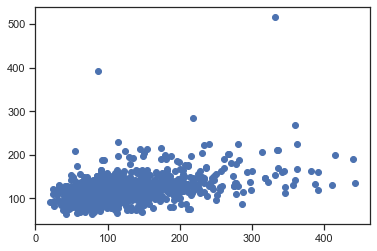

In [37]:
#Plotting the actual verses test y
plt.scatter(y_test, y_pred)

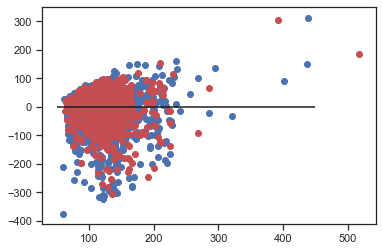

In [38]:
# Plotting the Residuals for the training data
plt.scatter(reg.predict(X_train[heatmap_feats]), reg.predict(X_train[heatmap_feats])- y_train, c='b')
plt.scatter(reg.predict(X_test[heatmap_feats]), reg.predict(X_test[heatmap_feats])- y_test, c='r')
plt.hlines(y=0, xmin=50, xmax=450)

It seems like the residuals are really off...Most of the data points are from 0-300, on the left, under 100 to -300.

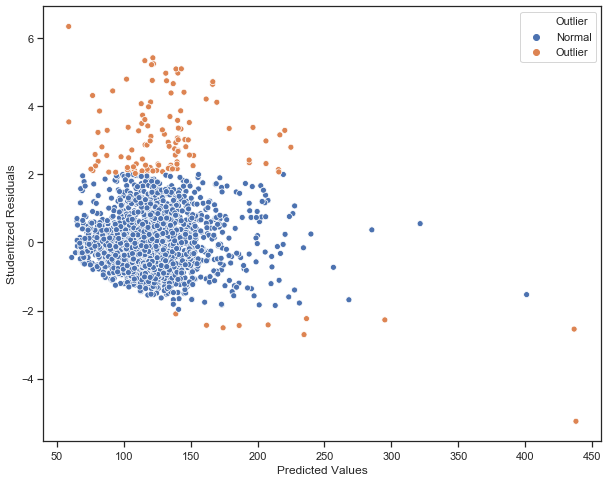

In [39]:
#Let's try to studentize them: divide the resideual by the estimate of the stdev of the residuals. 
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
mask_outliers = studresidplot(reg,X_train[heatmap_feats],y_train,threshold=2, ax = ax)

These studentized residuals look off too. HOMOSCHEDACITYYYYY!!!!! I guess transformation are warrented?

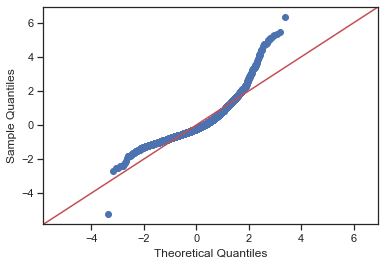

In [40]:
#QQ plot: to chck if residuals are not normally distributed
vals = {'Studentized Residuals': (y_train-reg.predict(X_train[heatmap_feats]))/rse(reg,X_train[heatmap_feats],y_train), 'Predicted Values': reg.predict(X_train[heatmap_feats])}

ax = sm.graphics.qqplot(vals['Studentized Residuals'], line='45')

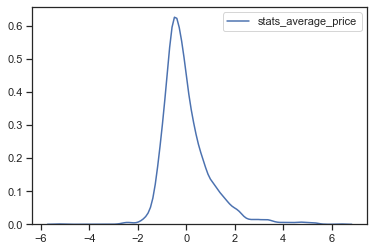

In [41]:
sns.kdeplot(vals['Studentized Residuals']);

QQplot is curvy...Also the residuals are skewed to the right.

In [42]:
# CHecking for multicollinearity
variance_inflation_factor(X_train[heatmap_feats].values,1)

1.4644800975685492

WTF? VIF is way lower than 10, which is a cut off for multicolinearity???

In [43]:
X_train1 = sm.add_constant(X_train[heatmap_feats])
model = sm.OLS(y_train, X_train1)
results = model.fit()
results.summary()

/Users/linhchau/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     stats_average_price   R-squared:                       0.176
Model:                             OLS   Adj. R-squared:                  0.174
Method:                  Least Squares   F-statistic:                     81.83
Date:                 Thu, 17 Oct 2019   Prob (F-statistic):          4.67e-108
Time:                         08:58:12   Log-Likelihood:                -14835.
No. Observations:                 2695   AIC:                         2.969e+04
Df Residuals:                     2687   BIC:                         2.973e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             66.8025     12.319      5.423      0.000      42.648      90.958
performers_num_upcoming_events     0.6257      0.108      5.793      0.000       0.414       0.837
venue_capacity                     0.0037      0.000     11.848      0.000       0.003       0.004
venue_score                       61.2876      7.735      7.923      0.000      46.120      76.455
acousticness                      27.7478     11.029      2.516      0.012       6.123      49.373
energy                           -27.7539     14.955     -1.856      0.064     -57.078       1.570
liveness                          88.4676     13.492      6.557      0.000      62.011     114.924
popularity_y                       0.2632      0.093      2.831      0.005       0.081       0.445
==============================================================================
Omnibus:                      966.871   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4396.767
Skew:                           1.678   Prob(JB):                         0.00
Kurtosis:                       8.281   Cond. No.                     8.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
results.pvalues

const                             6.386811e-08
performers_num_upcoming_events    7.704924e-09
venue_capacity                    1.323595e-31
venue_score                       3.362167e-15
acousticness                      1.192736e-02
energy                            6.358304e-02
liveness                          6.567836e-11
popularity_y                      4.674704e-03
dtype: float64

In [45]:
results.rsquared_adj

0.17356382702891837

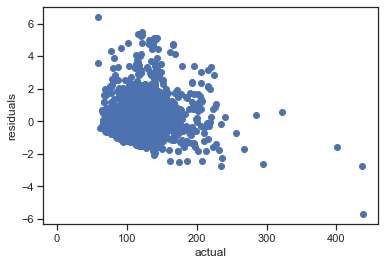

In [46]:
stud_resids = results.outlier_test()['student_resid']
plt.scatter(results.fittedvalues, stud_resids)
plt.hlines(0,2.25, 3.6, 'k', 
           linestyle='dashed',
           linewidth=3)
plt.xlabel('actual')
plt.ylabel('residuals');

Just did this with stats model too so I can get the fancy output. Super multicollinearity. Not sure which features to cut out. 

JB test is so far from zero, so my data is not normal. 

In [47]:
X_train2 = sm.add_constant(X_train['venue_capacity'])
model2 = sm.OLS(y_train, X_train2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     stats_average_price   R-squared:                       0.104
Model:                             OLS   Adj. R-squared:                  0.104
Method:                  Least Squares   F-statistic:                     313.2
Date:                 Thu, 17 Oct 2019   Prob (F-statistic):           2.19e-66
Time:                         08:58:16   Log-Likelihood:                -14948.
No. Observations:                 2695   AIC:                         2.990e+04
Df Residuals:                     2693   BIC:                         2.991e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            111.7059      1.300     85.903      0.000     109.156     114.256
venue_capacity     0.0051      0.000     17.697      0.000       0.005       0.006
==============================================================================
Omnibus:                      885.563   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3823.714
Skew:                           1.540   Prob(JB):                         0.00
Kurtosis:                       7.957   Cond. No.                     4.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
X_train3 = sm.add_constant(X_train['venue_capacity'])
model3 = sm.OLS(np.log(y_train), X_train3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     stats_average_price   R-squared:                       0.083
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     243.3
Date:                 Thu, 17 Oct 2019   Prob (F-statistic):           1.42e-52
Time:                         08:58:16   Log-Likelihood:                -1817.5
No. Observations:                 2695   AIC:                             3639.
Df Residuals:                     2693   BIC:                             3651.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.6074      0.010    462.675      0.000       4.588       4.627
venue_capacity  3.451e-05   2.21e-06     15.597      0.000    3.02e-05    3.88e-05
==============================================================================
Omnibus:                       36.262   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.761
Skew:                          -0.057   Prob(JB):                     2.35e-14
Kurtosis:                       3.739   Cond. No.                     4.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Thoughts on first, baby linear regression:

It seems like this regression doesn't really fit most of the assumptions of linear regression. 
    
__Linearity:__ most of the data look linear, like flat. The residuals look clustered though to the left. Maybe some transformation next?
    
__Homoscedaity:___ From residuals plot, the variance of the residuals are not constant.
    
__Normality:__ No. Look at the QQ plot. It look like squiggly worm.
    
__Multicollinearity:__ Getting mixed messages. PW correlation between the columns of focus, there seems to be correlations between the columns(around 0.1- 0.3ish) but the VIF is low???
    
__Next steps: Let's try the same model but with some transformations or backward selection and then Lasso with all the features!!!__

### Dealing with Multicollinearity

Looking at the OLS regression, it seems like there are some features concerning the venue and those concerning the musicality. But let's have LASSO deal with that. 

### Trying transformations and normalization

In [49]:
def linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression().fit(X_train, y_train)
    model.score(X_train, y_train)
    
    # Making Predictions using the testing set
    y_pred = model.predict(X_test)
   
    # Mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    
    # R2
    print("R2: %2f" % r2_score(y_test, y_pred))
    
    #Let's try to studentize them: divide the resideual by the estimate of the stdev of the residuals. 
    fig, ax = plt.subplots()
    fig.set_size_inches(10,8)
    mask_outliers = studresidplot(model,X_train,y_train,threshold=2, ax = ax)
    
    #QQ plot: to chck if residuals are not normally distributed
    vals = {'Studentized Residuals': (y_train-model.predict(X_train))/rse(model,X_train,y_train), 'Predicted Values': model.predict(X_train)}

    ax = sm.graphics.qqplot(vals['Studentized Residuals'], line='45')
    
    # VIF
    print("VIF: %2f" % variance_inflation_factor(X_train.values,1))

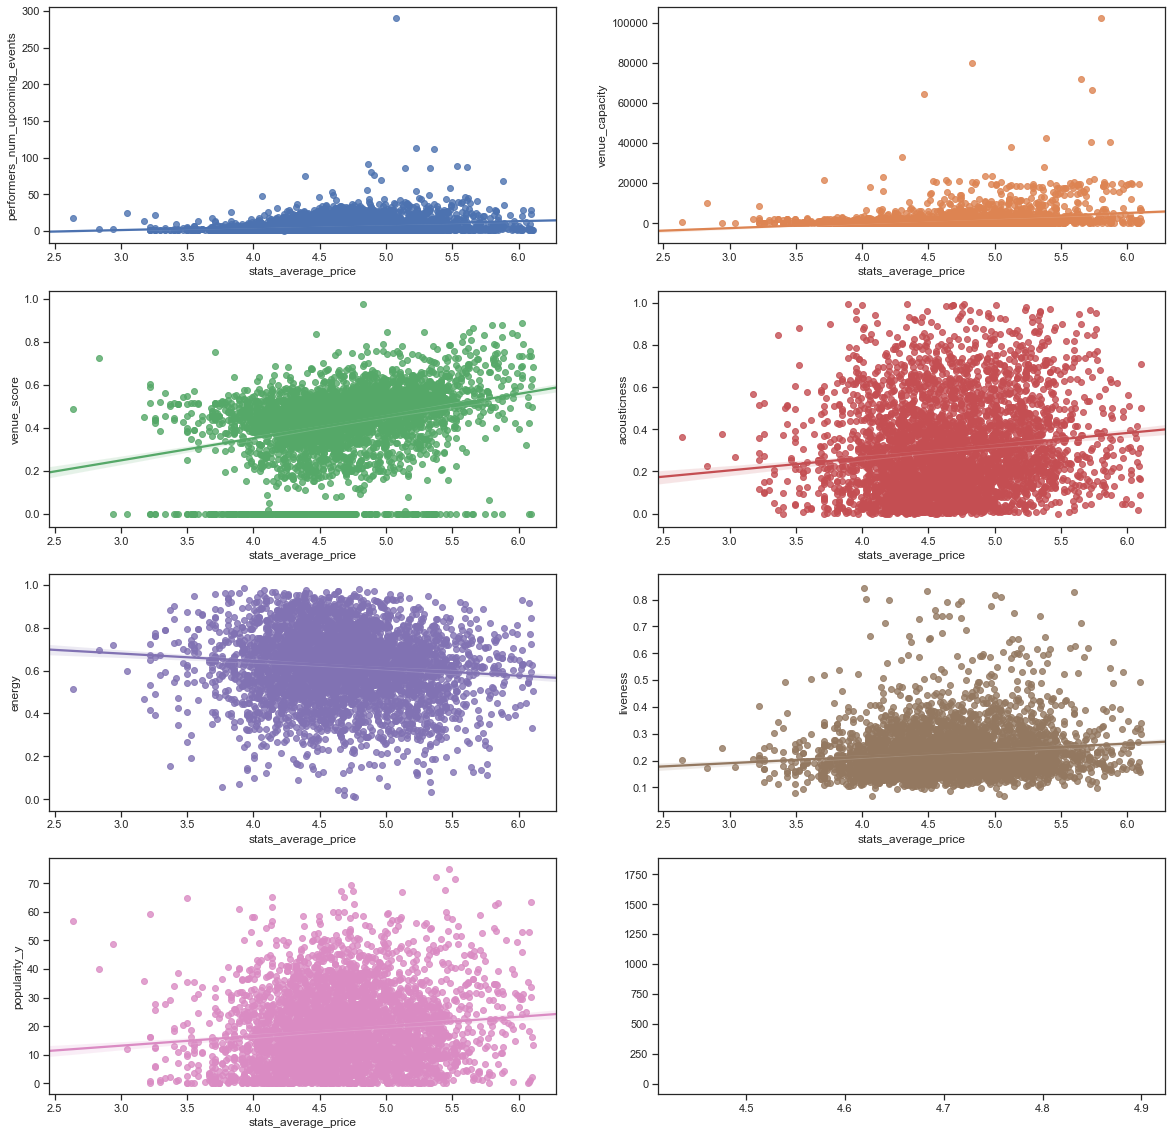

In [50]:
# let's look at log transforming
fig, axes = plt.subplots(4,2, figsize=(20,20))

for measure,ax in zip(heatmap_feats, axes.flat):
    sns.regplot(np.log(mean_df['stats_average_price']), mean_df[measure], ax = ax);

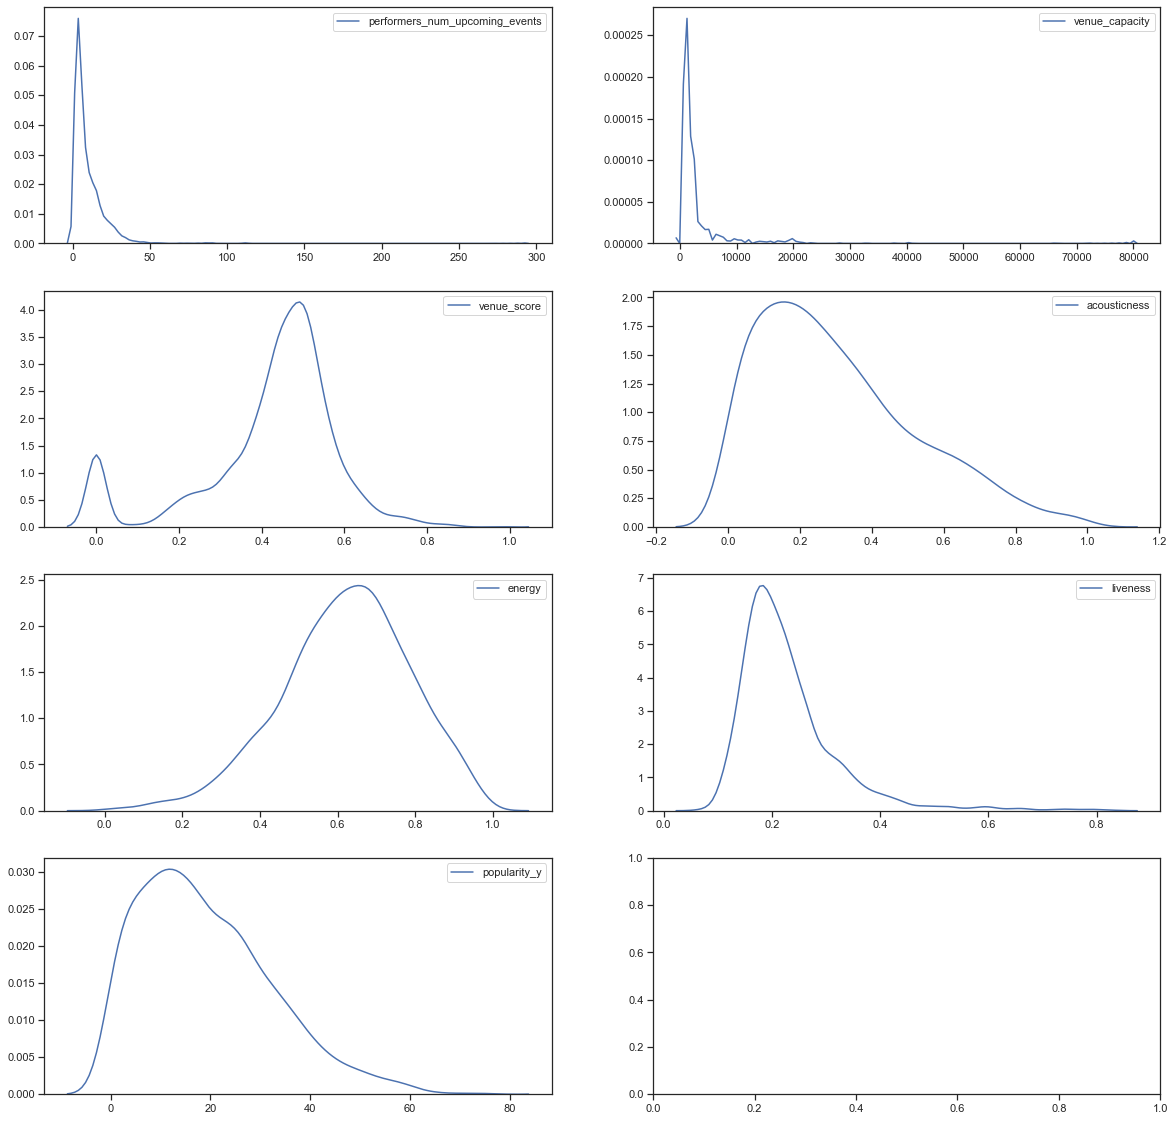

In [51]:
fig, axes = plt.subplots(4,2, figsize=(20,20))

for measure,ax in zip(heatmap_feats, axes.flat):
    sns.kdeplot(X_train[measure], ax =ax);

### Let's try to log transform the y

Mean squared error: 0.20
R2: 0.191834
VIF: 1.464480


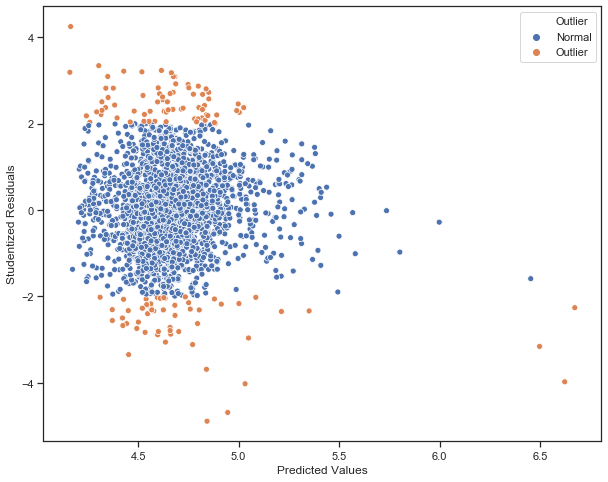

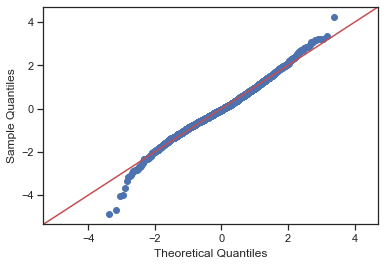

In [52]:
# Let's just log transform the y!
linear_regression(X_train[heatmap_feats], np.log(y_train), X_test[heatmap_feats], np.log(y_test))

The log transformation of y makes the qq-plot more normal looking. Log transform the independent variables???

/Users/linhchau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


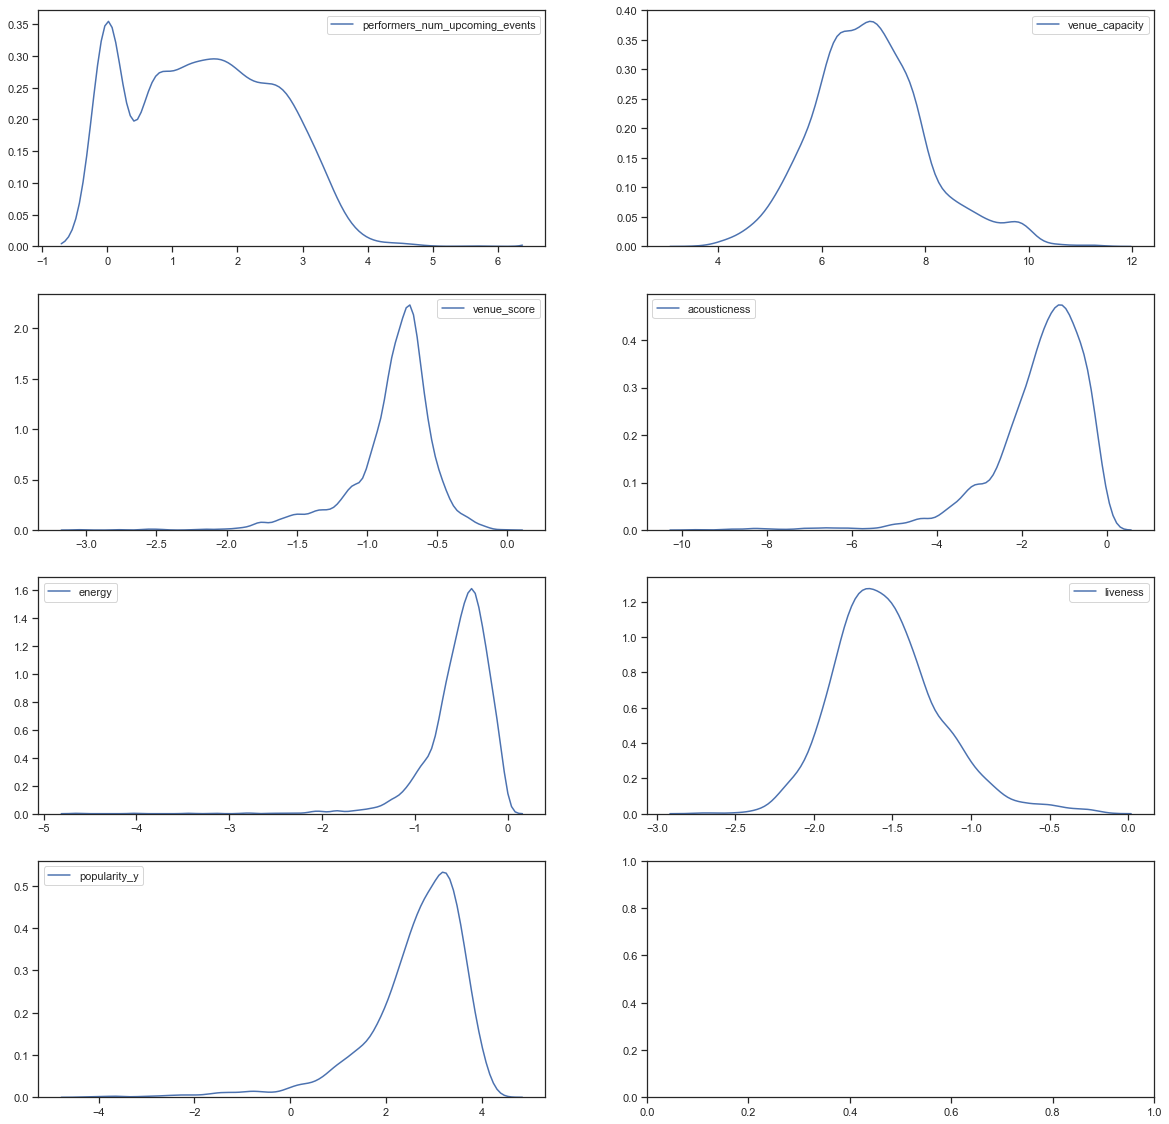

In [53]:
# histograms of log transformed independent variables
fig, axes = plt.subplots(4,2, figsize=(20,20))

for measure,ax in zip(heatmap_feats, axes.flat):
    sns.kdeplot(np.log(X_train[measure]), ax =ax);

EVERY THING STILL SKEWEEDDDDDD!

### BOX COX TRANFORMATION

https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

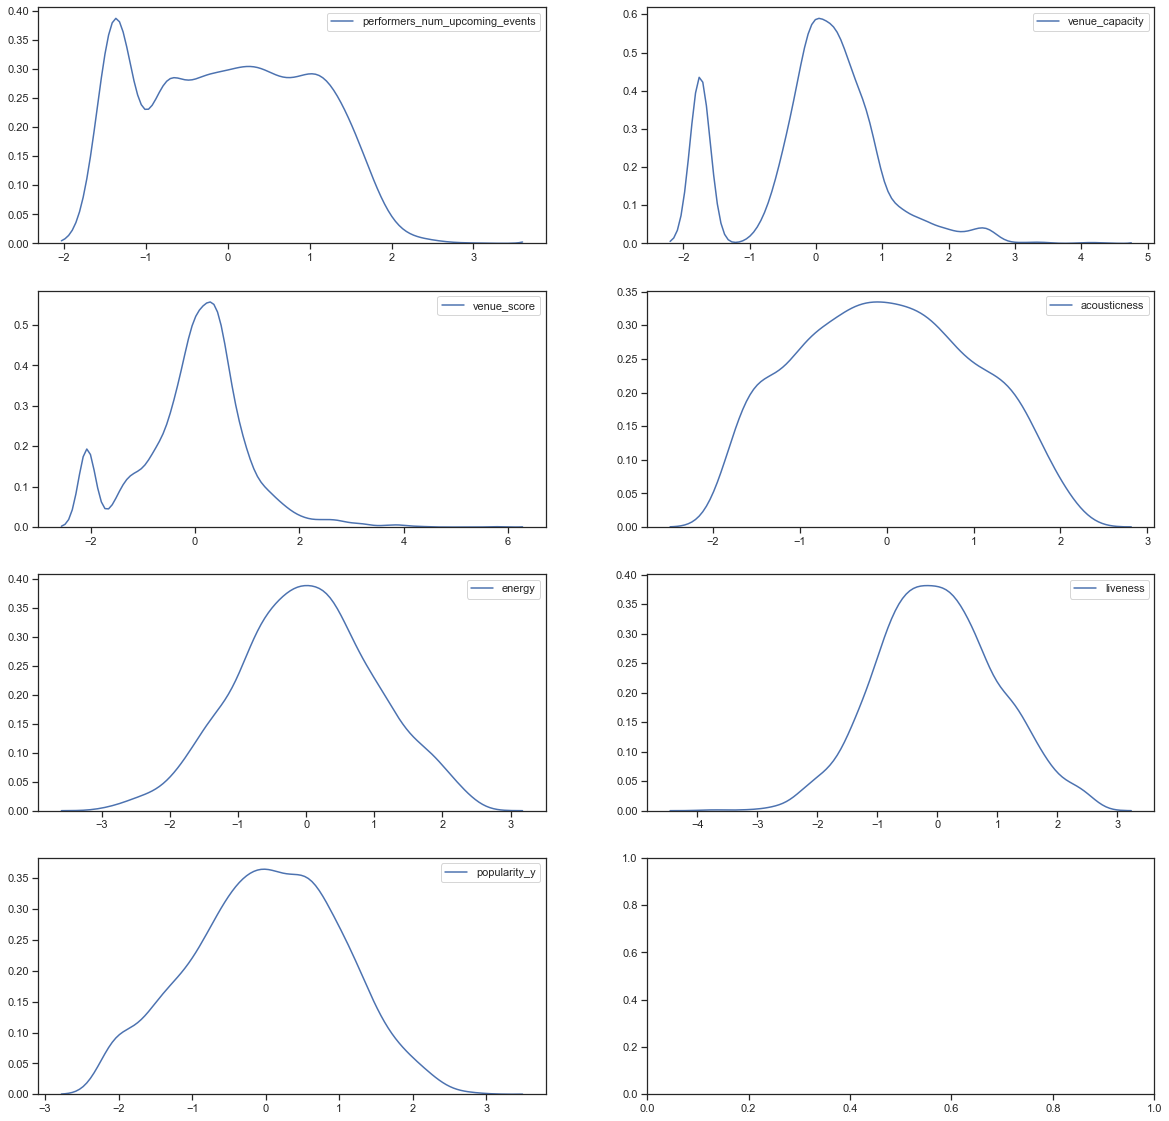

In [54]:
# What does the Box-Cox transformation do to the data

fig, axes = plt.subplots(4,2, figsize=(20,20))

# Transformation
X_train_trans = pd.DataFrame(power_transform(X_train[heatmap_feats], method='yeo-johnson'), columns=heatmap_feats)
X_test_trans = pd.DataFrame(power_transform(X_test[heatmap_feats], method='yeo-johnson'), columns=heatmap_feats)

X_train_trans

for measure,ax in zip(heatmap_feats, axes.flat):
    sns.kdeplot(X_train_trans[measure], ax =ax);

WTFFFFFF

In [75]:
X_train_trans.columns

Index(['performers_num_upcoming_events', 'venue_capacity', 'venue_score',
       'acousticness', 'energy', 'liveness', 'popularity_y'],
      dtype='object')

Mean squared error: 3225.83
R2: 0.226627
VIF: 2.428202


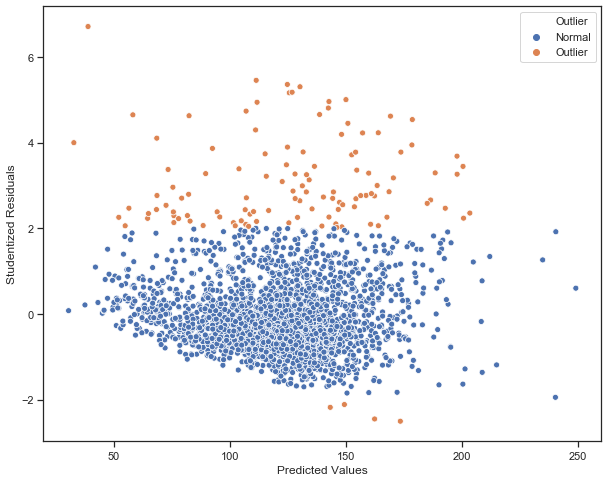

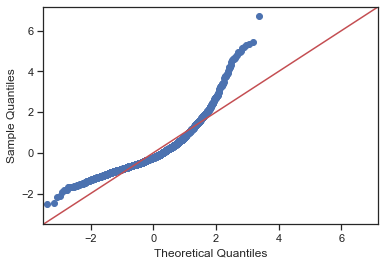

In [55]:
# With box cox transformation
linear_regression(X_train_trans, y_train, X_test_trans, y_test)

Mean squared error: 0.19
R2: 0.230356
VIF: 2.428202


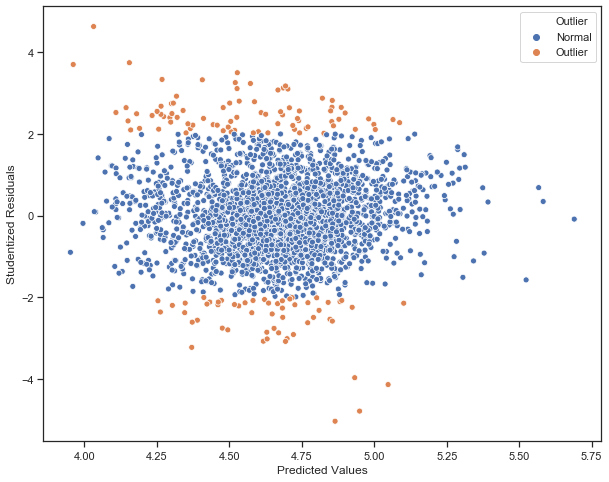

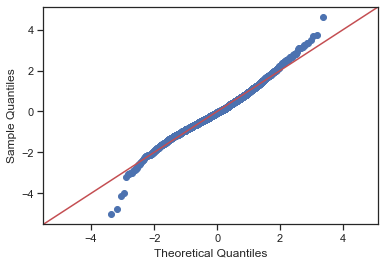

In [56]:
# With boxcox and log
linear_regression(X_train_trans, np.log(y_train), X_test_trans, np.log(y_test))

Seems like this is the best linear regression so far given the R2. Also, the qq plot is not too bad, just some skewness in the tails. Also, the studentidxed residuals are spread out a bit.

Mean squared error: 0.20
R2: 0.193822
VIF: 1.248034


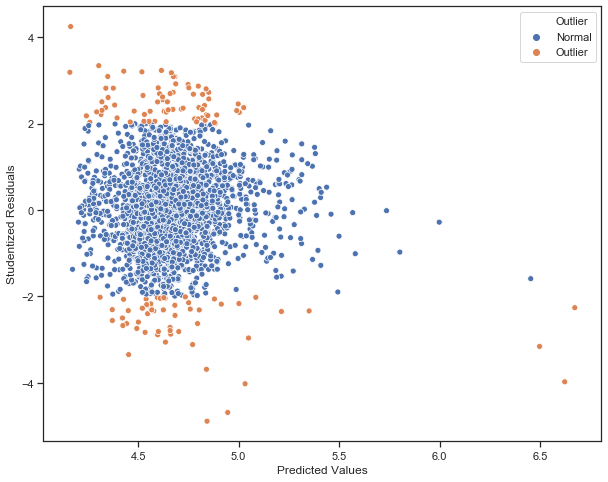

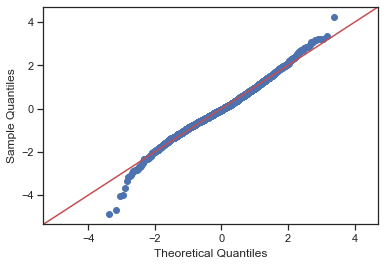

In [57]:
### Transformation with Standard Scaler

X_train_scaled = pd.DataFrame(preprocessing.scale(X_train[heatmap_feats]))
X_test_scaled = pd.DataFrame(preprocessing.scale(X_test[heatmap_feats]))

linear_regression(X_train_scaled, np.log(y_train), X_test_scaled, np.log(y_test))

This linear model with just the standardized X features and log transformed ys is not too bad but residuals are still clusteres and the R2 are ok compared to the first linear regression.

# PREDICTOR!!!!!!

Let's try a random forest model!

In [58]:
X_train.columns

# Rm extra columns
useful_col = ['performers_num_upcoming_events',
        'popularity_x', 'score', 'taxonomies_id', 'venue_capacity', 'venue_id',
       'venue_metro_code', 'venue_num_upcoming_events', 'venue_popularity',
       'venue_score', 'unique_venue_ratio', 'residency', 
        'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity_y']

X_train_all = X_train[useful_col]
X_test_all = X_test[useful_col]

In [59]:
X_train_all

,performers_num_upcoming_events,popularity_x,score,taxonomies_id,venue_capacity,venue_id,venue_metro_code,venue_num_upcoming_events,venue_popularity,venue_score,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_y
3752,7.000000,0.421429,0.361143,2000000.0,446.428571,63446.571429,595.857143,51.714286,0.0,0.421394,...,0.174291,0.688616,0.694535,0.025813,0.174047,-6.284566,0.085615,115.623434,0.506808,15.424242
2951,1.000000,0.000000,0.000000,2000000.0,1800.000000,1084.000000,803.000000,40.000000,0.0,0.543996,...,0.661455,0.587364,0.235527,0.234327,0.138809,-18.432727,0.101264,110.660000,0.344791,9.000000
3085,2.000000,0.460000,0.343000,2000000.0,600.000000,7952.000000,524.000000,70.000000,0.0,0.492207,...,0.497862,0.703402,0.484676,0.424727,0.136557,-11.033717,0.068778,120.143250,0.523939,35.347826
2351,1.000000,0.000000,0.000000,2000000.0,0.000000,441404.000000,501.000000,16.000000,0.0,0.000000,...,0.039152,0.386057,0.963064,0.067212,0.247034,-4.098255,0.109126,127.924064,0.375155,1.276596
2217,9.000000,0.402750,0.389500,2000000.0,965.625000,1956.000000,518.250000,33.375000,0.0,0.488919,...,0.351083,0.567133,0.638327,0.319282,0.157196,-9.299212,0.060358,113.647691,0.660495,9.654545
2331,15.000000,0.514000,0.401500,2000000.0,1007.000000,1171.500000,514.000000,29.000000,0.0,0.451600,...,0.031271,0.456323,0.885151,0.006085,0.184731,-4.122667,0.111820,138.921022,0.405888,30.139785
2822,1.000000,0.554000,0.511000,2000000.0,2750.000000,3670.000000,635.000000,74.000000,0.0,0.633570,...,0.329352,0.539113,0.594149,0.026539,0.352015,-8.349504,0.068892,117.381418,0.477367,25.432624
3560,18.000000,0.314214,0.322143,2000000.0,1042.500000,51989.428571,629.500000,27.428571,0.0,0.434745,...,0.717636,0.517273,0.393399,0.549839,0.310737,-12.395361,0.050807,122.761608,0.489552,15.824742
2241,3.000000,0.497000,0.431000,2000000.0,537.500000,6180.500000,253.000000,61.500000,0.0,0.495798,...,0.209096,0.460857,0.697993,0.059293,0.205076,-6.025235,0.071214,128.875412,0.460854,3.319328
2225,1.000000,0.000000,0.000000,2000000.0,0.000000,9437.000000,669.000000,6.000000,0.0,0.448056,...,0.252800,0.684315,0.652728,0.002312,0.154564,-6.243865,0.072891,123.516399,0.597831,7.398876


In [76]:
X_train_all.shape

(2695, 22)

In [60]:
# Test random forest

#Train and fit model
rf = RandomForestRegressor(n_estimators = 1000,
                           max_features = 'auto',
                           random_state = 0
                            )

rf.fit(X_train_all, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [61]:
# Test Prediction
rf_pred = rf.predict(X_test_all)

print(f"accuracy = {rf.score(X_test_all, y_test)}")

accuracy = 0.4031096845070401


That's pretty good given the regression scores.

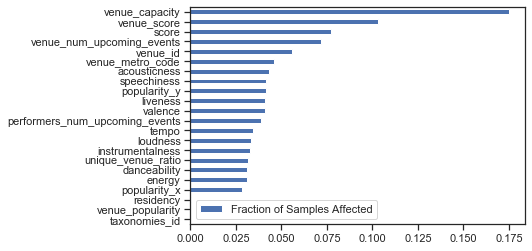

In [62]:
# Plot feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_}, index=X_train_all.columns)

feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')

In [63]:
# Trying a paramete search
model = RandomForestRegressor()

param_grid = {
    "n_estimators": [10, 100, 1000, 10000], # num of trees
    "max_depth": [2,3,4],
    "max_features": ['auto', 'sqrt', 'log2'] # num of features when considering where to split
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train_all, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

KeyboardInterrupt: 

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(grid_search.cv_results_)

In [ ]:
grid_search.best_params_

In [70]:
# Doing the Random Forest with the Grid search parameters
#Train and fit model
rf_gs = RandomForestRegressor(n_estimators = 10000,
                           max_features = 'auto',
                           max_depth = 4,
                           random_state = 0
                            )

rf_gs.fit(X_train_all, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [71]:
# Test Prediction
rf_gs_pred = rf_gs.predict(X_test_all)

print(f"accuracy = {rf_gs.score(X_test_all, y_test)}")

accuracy = 0.34364104097017123


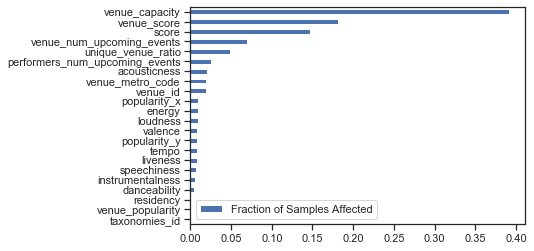

In [72]:
# Plot feature importance
feat_scores_gs = pd.DataFrame({'Fraction of Samples Affected' : rf_gs.feature_importances_}, index=X_train_all.columns)

feat_scores_gs = feat_scores_gs.sort_values(by='Fraction of Samples Affected')
feat_scores_gs.plot(kind='barh')

In [73]:
rf_gs.n_features_

22

In [68]:
# Doing the Random Forest with the Grid search parameters
#Train and fit model
rf_gs1 = RandomForestRegressor(n_estimators = 10000,
                           max_features = 'auto',
                           max_depth = 5,
                           random_state = 0
                            )

rf_gs1.fit(X_train_all, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [74]:
print(f"accuracy = {rf_gs1.score(X_test_all, y_test)}")

accuracy = 0.3649083653121207


In [66]:
# Doing the Random Forest with increased max depth
#Train and fit model
rf_2 = RandomForestRegressor(n_estimators = 10000,
                           max_features = 'auto',
                           max_depth = 10,
                           random_state = 0
                            )

rf_2.fit(X_train_all, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [67]:
print(f"accuracy = {rf_2.score(X_test_all, y_test)}")

accuracy = 0.3992652835048286
